# SageWrite Notebook
The following notebook is divided into the following sections:
<ol>
    <li> Data Exploration </li>
    <li> Text Classification </li>
    <li> Text Generation </li>
</ol>

In [315]:
import pandas as pd
from typing import List
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib import pyplot
import Levenshtein
import torch.nn as nn
from transformers import RobertaTokenizer, RobertaModel
import torch
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
import torch.nn.functional as F
import math

## Data Exploration
In this segment, we are going to explore the text length distrubtion of the 100 articles we have. Moreover, we are trying to find different insights in the text that might serve the final purpose (write better articles). 

One of the insights was to check the correlation between the length of the outline draft and the original text. This might seem counter intuitive in the beginning, however, we believe that there is a hidden golden ratio between a draft and final text. Then by applying this to larger dataset (because numbers here can be tricky due to data size) we can find great insights about the ratio we need to filter against to maintain high quality data to train our model on for enhancing our final article.

In [7]:
dataset = pd.read_csv('SageWrite_corpus_0.1.csv')

In [17]:
dataset.describe()

,sb_summary_id,original_text_id,colloquial_language,formal_language,unnecessary_jargon,verbosity,opaque_writing,overly_long_sentences,excessively_complex_syntax,abuse_of_passive_sentences,...,pretentiousness,engaging_writing,dull_writing,unclear,word_choice,repetition,fragment,non_sequitor,poor_flow,redundant
count,100.000000,100.000000,100.000000,100.00,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,50.500000,124.850000,0.020000,0.01,0.080000,0.020000,0.360000,0.060000,0.070000,0.030000,...,0.030000,0.130000,0.140000,0.590000,0.500000,0.040000,0.150000,0.090000,0.140000,0.080000
std,29.011492,42.632651,0.140705,0.10,0.338744,0.140705,0.502921,0.277798,0.293189,0.171447,...,0.171447,0.337998,0.402517,0.995901,0.870388,0.242878,0.435194,0.404395,0.426875,0.307482
min,1.000000,52.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.750000,97.750000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.500000,122.500000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,75.250000,168.250000,0.000000,0.00,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.000000,195.000000,1.000000,1.00,2.000000,1.000000,2.000000,2.000000,2.000000,1.000000,...,1.000000,1.000000,2.000000,3.000000,3.000000,2.000000,2.000000,3.000000,2.000000,2.000000


In [30]:
sns.set_theme(style="darkgrid")

def length_distrubtion(text : list) -> list:
    text_length = []
    
    for t in text:
        t = re.sub('\n','',t)
        tokens = t.split(' ')
        text_length.append(len(tokens))
        
    sns.barplot(x=[i for i in range(100)],y=text_length);
    return text_length

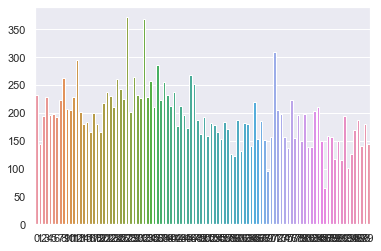

In [32]:
original_text_length = length_distrubtion(dataset['original_text'])

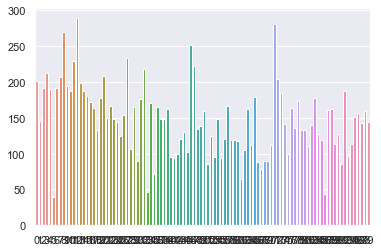

In [33]:
outline_1_text_length = length_distrubtion(dataset['outline_1'])

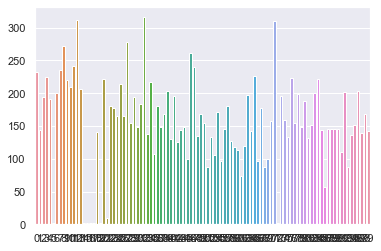

In [34]:
outline_2_text_length = length_distrubtion(dataset['outline_2'])

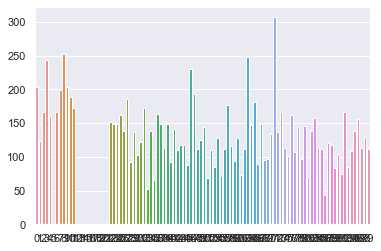

In [35]:
outline_3_text_length = length_distrubtion(dataset['outline_3'])

## Insights after bar-plot
We can notice that outline 2, 3 have some empty text scattered across. 

In [69]:
def calculate_and_plot_pearson(original_text_length: list,outline_text_length: list)-> None:
    print(f'Correlation coefficient is : {stats.pearsonr(original_text_length,outline_text_length)}')
    pyplot.scatter(original_text_length,outline_text_length)
    pyplot.xlabel("Length of original text")
    pyplot.ylabel("Length of Outline")
    pyplot.show()

In [85]:
def calculate_average_ratio(original_text_length: list, outline_text_length: list) -> int:
    average_ratio = 0
    
    for i in zip(original_text_length,outline_text_length):
        if i[0] == 0 or i[1] == 0:
            continue
        average_ratio += (i[1] / i[0])
    
    return average_ratio / len(original_text_length)

Correlation coefficient is : (0.601260144328335, 3.7257864147540507e-11)


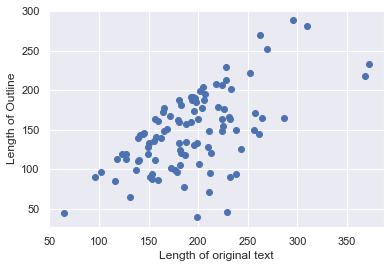

Average Ratio between original length and outline length: 0.7739341282370215


In [86]:
calculate_and_plot_pearson(original_text_length,outline_1_text_length)
print(f'Average Ratio between original length and outline length: {calculate_average_ratio(original_text_length,outline_1_text_length)}')

Correlation coefficient is : (0.5884883878516578, 1.2038501461187022e-10)


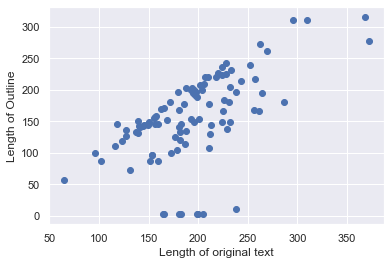

Average Ratio between original length and outline length: 0.8125309379712194


In [87]:
calculate_and_plot_pearson(original_text_length,outline_2_text_length)
print(f'Average Ratio between original length and outline length: {calculate_average_ratio(original_text_length,outline_2_text_length)}')

Correlation coefficient is : (0.37490400049574074, 0.00012151056023146377)


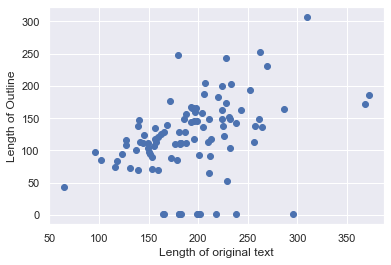

Average Ratio between original length and outline length: 0.6328576048403345


In [88]:
calculate_and_plot_pearson(original_text_length,outline_3_text_length)
print(f'Average Ratio between original length and outline length: {calculate_average_ratio(original_text_length,outline_3_text_length)}')

## Insights after scatter-plot
We can start noticing specific pattern where the distrubtion of the scatter-plot is common between them all which is roughly ranges between 0.6:1 and 0.8:1 or 1:1.25 and 1:1.667 

## One step further
As a final check for the data analysis, we are going to check the normal edit distance between the Original text and the Outline to have a gesture about how much different the text is. As a more complex measurement we are going to use a Sentence Transformer to calculate a sentence representation embedding and calculate cosine similarity to find out how similar they are in terms of context.

In [65]:
edit_distance_average = 0
# Edit Distance is 1 - Similarity (How much we need to change the text to be 100% similar)
for i in zip(dataset['original_text'],dataset['outline_1']):
     edit_distance_average += 1 - Levenshtein.ratio(i[0],i[1])
      
print(f'Edit distance for Outline 1 and Original Text: {edit_distance_average / len(dataset)}')

Edit distance for Outline 1 and Original Text: 0.2601910128717278


In [66]:
edit_distance_average = 0

for i in zip(dataset['original_text'],dataset['outline_2']):
     edit_distance_average += 1 - Levenshtein.ratio(i[0],i[1])
      
print(f'Edit distance for Outline 2 and Original Text: {edit_distance_average / len(dataset)}')

Edit distance for Outline 2 and Original Text: 0.16992249960771214


In [67]:
edit_distance_average = 0

for i in zip(dataset['original_text'],dataset['outline_3']):
     edit_distance_average += 1 - Levenshtein.ratio(i[0],i[1])
      
print(f'Edit distance for Outline 2 and Original Text: {edit_distance_average / len(dataset)}')

Edit distance for Outline 2 and Original Text: 0.3802138721446551


In [95]:
from sentence_transformers import SentenceTransformer, util

In [92]:
mpnet = SentenceTransformer('all-mpnet-base-v2')

## Contextual Similarity Approach
It is time to find whether the length indicates anything useful for the business case using the contextual similarity approachg. We are going to use a transformer called MPNET (https://arxiv.org/abs/2004.09297) one of the sentence transformer state-of-the-art in STS-B tasks. However the used version is fine-tuned on Paraphrashing and sentence similarity tasks while the original model is pretrained as a language model.

In [93]:
original_embeddings = mpnet.encode(dataset['original_text'])
outline_1_embeddings = mpnet.encode(dataset['outline_1'])
outline_2_embeddings = mpnet.encode(dataset['outline_2'])
outline_3_embeddings = mpnet.encode(dataset['outline_3'])

In [100]:
outline_1_average_similarity = util.pytorch_cos_sim(original_embeddings,outline_1_embeddings).trace() / original_embeddings.shape[0]
outline_1_average_similarity.item()

0.9406161308288574

In [101]:
outline_2_average_similarity = util.pytorch_cos_sim(original_embeddings,outline_2_embeddings).trace() / original_embeddings.shape[0]
outline_2_average_similarity.item()

0.8823512196540833

In [102]:
outline_3_average_similarity = util.pytorch_cos_sim(original_embeddings,outline_3_embeddings).trace() / original_embeddings.shape[0]
outline_3_average_similarity.item()

0.8160586357116699

## Hypothesis
It seems like outline with the highest text lenght correlation and the highest sentence similarity is of the highest quality. (This assumes that high contextual similarity reflects quality while having high correlation in the text length, this can reflect that the writer increased the text lenght maintaining the same topic/context of the text).

## ==========================================================================

## Text Classification
In the next section, we are going to create a classification model for the 19 different categories we have. In the next paragraph, i am going to explain the methodology used and explain every small detail. 
First of all, pretrained language models are quite the standard now to be used for downstream tasks like text classificiaton, question answering and so on. So i am going to use RoBERTa pretrained model https://arxiv.org/abs/1907.11692 as a feature extractor returning a numeric vector having the sentence representation. 

The pipeline is as the following: Raw text -> RoBERTa Model -> Pooler Output -> 2-Layer Feedforward Network as Classification Layer. Moreover, i have divided the classification tasks into different piles so that the classification model would be as specialized as possible treating it as a literature critique. Finally, i changed each label to be a binary label for training conventions, for example, we have labels ranging from 0-3, so for each label such as dull_writing there is going to be a dummy label for 0, for 1 and so on called dull_writing_0, dull_writing_1.

In [1]:
def init_roberta_model(gpu_usage):
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    model = RobertaModel.from_pretrained('roberta-base')
    if gpu_usage:
        model.to('cuda')
    return tokenizer,model

In [80]:
class Classification_Model(nn.Module):
    
    def __init__(self,input_dim,hidden_size,num_classes):
        super(Classification_Model,self).__init__()
        self.ff = nn.Linear(input_dim,hidden_size)
        self.out = nn.Linear(hidden_size,num_classes)
        self.selu = nn.SELU()
        
    def forward(self,x,batch_size):
        x = self.selu(self.ff(x))
        x = x.reshape(batch_size,-1)
        x = self.out(x)
        return x

In [8]:
def train_test_split(dataset,labels,test_size=25):
    perm = torch.randperm(dataset.size()[0])
    full_dataset = dataset[perm]
    full_labels = labels[perm]
    test_dataset = full_dataset[-test_size:]
    test_labels = full_labels[-test_size:]
    train_dataset = full_dataset[:-test_size]
    train_labels = full_labels[:-test_size]
    return train_dataset,train_labels,test_dataset,test_labels

In [102]:
def transformer_model_dataset_preparation(dataset,model,tokenizer,max_length):
    model_output = []
    model.eval()
    with torch.no_grad():
        for sent in dataset:
            tokenized_sentence = tokenizer(sent,padding='max_length',max_length=max_length,truncation=True,return_tensors='pt')
            model_sent = model(**tokenized_sentence.to('cuda'))
            model_output.append(model_sent[1].detach().cpu().numpy())
            del model_sent
            del tokenized_sentence
    model_output = torch.from_numpy(np.array(model_output))
    return model_output

In [153]:
def labels_preprocessing(dataset,column):
    labels = pd.get_dummies(dataset[column])
    dummies_names = []
    for i in labels.columns:
        dummies_names.append(str(column+'_'+str(i)))
    labels = labels.to_numpy()
    labels = torch.from_numpy(labels)
    return labels, dummies_names

In [154]:
text_dataset = dataset['original_text'].tolist()
labels = dataset.iloc[:,6:]

In [19]:
roberta_tokenizer, roberta_model = init_roberta_model(gpu_usage=True)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [103]:
roberta_processed_text = transformer_model_dataset_preparation(text_dataset,roberta_model,roberta_tokenizer,max_length=380)

In [158]:
import itertools

In [161]:
list(itertools.chain(*[[1,2,3],[4,5,6]]))

[1, 2, 3, 4, 5, 6]

In [105]:
columns = labels.columns

In [106]:
lexical_dimension = columns[:5]
syntactic_propertie = columns[6:11]
others = columns[11:]

In [162]:
def prepare_label_specific_tensors(labels,columns):
    dummies = []
    container_tensor, dummies_names = labels_preprocessing(labels,columns[0])
    dummies.append(dummies_names)
    for i in columns[1:]:
        labels_tensor,dummies_names = labels_preprocessing(labels,i)
        dummies.append(dummies_names) 
        container_tensor = torch.cat((container_tensor,labels_tensor),dim=-1)
    dummies = list(itertools.chain(*dummies))
    return container_tensor,dummies

In [163]:
lexical_dimension_labels, dummies = prepare_label_specific_tensors(labels,lexical_dimension)
train_dataset,train_labels,test_dataset,test_labels = train_test_split(roberta_processed_text,lexical_dimension_labels,test_size=25)
class_model = Classification_Model(input_dim = 768,hidden_size=768,num_classes = lexical_dimension_labels.shape[1])
class_model.to('cuda')

Classification_Model(
  (ff): Linear(in_features=768, out_features=768, bias=True)
  (out): Linear(in_features=768, out_features=12, bias=True)
  (selu): SELU()
)

In [166]:
batch_size = 25
n_batches = math.ceil(len(train_dataset) // batch_size)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(class_model.parameters(),lr=0.0004)
epochs = 10
for epoch in range(epochs):
    batch_losses = []
    for i in range(n_batches):
        class_model.train()
        optimizer.zero_grad()
        local_X, local_y = train_dataset[max(0,i * batch_size):min(len(train_dataset),(i+1) * batch_size)] , train_labels[max(0,i * batch_size):min(len(train_labels),(i+1) * batch_size)]
        output = class_model(local_X.float().cuda(),batch_size)
        loss = criterion(output,local_y.cuda().float())
        batch_losses.append(loss.item())
        loss.backward()
        optimizer.step() 
    print('Loss value:'+str(sum(batch_losses)/len(batch_losses)))
    class_model.eval()
    with torch.no_grad():
        test_out = class_model(test_dataset.float().cuda(),len(test_dataset))
        print('Test Results Epoch '+str(epoch)+':')
        print(metrics.classification_report(test_out.detach().cpu().numpy()>0.5,test_labels.numpy(),target_names=dummies))
        


Loss value:0.3402113715807597
Test Results Epoch 0:
                       precision    recall  f1-score   support

colloquial_language_0       1.00      0.96      0.98        25
colloquial_language_1       0.00      0.00      0.00         0
    formal_language_0       1.00      0.96      0.98        25
    formal_language_1       0.00      0.00      0.00         0
 unnecessary_jargon_0       1.00      0.96      0.98        25
 unnecessary_jargon_1       0.00      0.00      0.00         0
 unnecessary_jargon_2       0.00      0.00      0.00         0
          verbosity_0       1.00      1.00      1.00        25
          verbosity_1       0.00      0.00      0.00         0
     opaque_writing_0       1.00      0.60      0.75        25
     opaque_writing_1       0.00      0.00      0.00         0
     opaque_writing_2       0.00      0.00      0.00         0

            micro avg       0.90      0.90      0.90       125
            macro avg       0.42      0.37      0.39       125
 

C:\Users\ahmed\anaconda3\envs\opennmttorch\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ahmed\anaconda3\envs\opennmttorch\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ahmed\anaconda3\envs\opennmttorch\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\

In [169]:
syntactic_propertie_labels, dummies = prepare_label_specific_tensors(labels,syntactic_propertie)
train_dataset,train_labels,test_dataset,test_labels = train_test_split(roberta_processed_text,syntactic_propertie_labels,test_size=25)
class_model = Classification_Model(input_dim = 768,hidden_size=768,num_classes = syntactic_propertie_labels.shape[1])
class_model.to('cuda')

Classification_Model(
  (ff): Linear(in_features=768, out_features=768, bias=True)
  (out): Linear(in_features=768, out_features=12, bias=True)
  (selu): SELU()
)

In [170]:
batch_size = 25
n_batches = math.ceil(len(train_dataset) // batch_size)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(class_model.parameters(),lr=0.0004)
epochs = 10
for epoch in range(epochs):
    batch_losses = []
    for i in range(n_batches):
        class_model.train()
        optimizer.zero_grad()
        local_X, local_y = train_dataset[max(0,i * batch_size):min(len(train_dataset),(i+1) * batch_size)] , train_labels[max(0,i * batch_size):min(len(train_labels),(i+1) * batch_size)]
        output = class_model(local_X.float().cuda(),batch_size)
        loss = criterion(output,local_y.cuda().float())
        batch_losses.append(loss.item())
        loss.backward()
        optimizer.step() 
    print('Loss value:'+str(sum(batch_losses)/len(batch_losses)))
    class_model.eval()
    with torch.no_grad():
        test_out = class_model(test_dataset.float().cuda(),len(test_dataset))
        print('Test Results Epoch '+str(epoch)+':')
        print(metrics.classification_report(test_out.detach().cpu().numpy()>0.5,test_labels.numpy(),target_names=dummies))

Loss value:0.5973155299822489
Test Results Epoch 0:
                              precision    recall  f1-score   support

excessively_complex_syntax_0       1.00      1.00      1.00        25
excessively_complex_syntax_1       0.00      0.00      0.00         0
excessively_complex_syntax_2       0.00      0.00      0.00         0
abuse_of_passive_sentences_0       1.00      1.00      1.00        25
abuse_of_passive_sentences_1       0.00      0.00      0.00         0
           clear_structure_0       0.00      0.00      0.00         0
           clear_structure_1       0.00      0.00      0.00         0
           clear_structure_2       0.00      0.00      0.00         0
           pretentiousness_0       1.00      0.96      0.98        25
           pretentiousness_1       0.00      0.00      0.00         0
          engaging_writing_0       1.00      0.88      0.94        25
          engaging_writing_1       0.00      0.00      0.00         0

                   micro avg       0

C:\Users\ahmed\anaconda3\envs\opennmttorch\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ahmed\anaconda3\envs\opennmttorch\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ahmed\anaconda3\envs\opennmttorch\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\

In [171]:
others_labels, dummies = prepare_label_specific_tensors(labels,others)
train_dataset,train_labels,test_dataset,test_labels = train_test_split(roberta_processed_text,others_labels,test_size=25)
class_model = Classification_Model(input_dim = 768,hidden_size=768,num_classes = others_labels.shape[1])
class_model.to('cuda')

Classification_Model(
  (ff): Linear(in_features=768, out_features=768, bias=True)
  (out): Linear(in_features=768, out_features=27, bias=True)
  (selu): SELU()
)

In [172]:
batch_size = 25
n_batches = math.ceil(len(train_dataset) // batch_size)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(class_model.parameters(),lr=0.0004)
epochs = 10
for epoch in range(epochs):
    batch_losses = []
    for i in range(n_batches):
        class_model.train()
        optimizer.zero_grad()
        local_X, local_y = train_dataset[max(0,i * batch_size):min(len(train_dataset),(i+1) * batch_size)] , train_labels[max(0,i * batch_size):min(len(train_labels),(i+1) * batch_size)]
        output = class_model(local_X.float().cuda(),batch_size)
        loss = criterion(output,local_y.cuda().float())
        batch_losses.append(loss.item())
        loss.backward()
        optimizer.step() 
    print('Loss value:'+str(sum(batch_losses)/len(batch_losses)))
    class_model.eval()
    with torch.no_grad():
        test_out = class_model(test_dataset.float().cuda(),len(test_dataset))
        print('Test Results Epoch '+str(epoch)+':')
        print(metrics.classification_report(test_out.detach().cpu().numpy()>0.5,test_labels.numpy(),target_names=dummies))

Loss value:0.6132851839065552
Test Results Epoch 0:
                precision    recall  f1-score   support

dull_writing_0       1.00      0.80      0.89        25
dull_writing_1       0.00      0.00      0.00         0
dull_writing_2       0.00      0.00      0.00         0
     unclear_0       0.00      0.00      0.00         0
     unclear_1       0.00      0.00      0.00         0
     unclear_2       0.00      0.00      0.00         0
     unclear_3       0.00      0.00      0.00         0
 word_choice_0       0.06      1.00      0.12         1
 word_choice_1       0.00      0.00      0.00         0
 word_choice_2       0.00      0.00      0.00         0
 word_choice_3       0.00      0.00      0.00         0
  repetition_0       1.00      0.96      0.98        25
  repetition_1       0.00      0.00      0.00         0
  repetition_2       0.00      0.00      0.00         0
    fragment_0       1.00      0.80      0.89        25
    fragment_1       0.00      0.00      0.00      

C:\Users\ahmed\anaconda3\envs\opennmttorch\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ahmed\anaconda3\envs\opennmttorch\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ahmed\anaconda3\envs\opennmttorch\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\

## Text Generation
In this final section, i am going to training a Seq-2-Seq model to generate text from "outline-1" to the original text immitating the improvement of text as my understandment. The model is using RoBERTa as its encoder and 2-layer transformer decoders. The decoders is the normal "attention is all you need" decoders with 2 attention heads and 2048 as FFN. I have worked on this text2text generation before and training the model with unfrozen layers achieve much better performance specially for domain specific tasks like this one exactly. Most of the internal parameters chosen are very similar to my experimentations with Machine Translation models.

In [314]:
def get_pad_mask(seq, pad_idx):
    return (seq != pad_idx).unsqueeze(-2)


def get_subsequent_mask(seq):
    sz_b, len_s = seq.size()
    subsequent_mask = (1 - torch.triu(
        torch.ones((1, len_s, len_s), device=seq.device), diagonal=1)).bool()
    return subsequent_mask

class PositionalEncoding(nn.Module):

    def __init__(self, d_hid, n_position=200):
        super(PositionalEncoding, self).__init__()
        self.register_buffer('pos_table', self._get_sinusoid_encoding_table(n_position, d_hid))

    def _get_sinusoid_encoding_table(self, n_position, d_hid):
        def get_position_angle_vec(position):
            return [position / np.power(10000, 2 * (hid_j // 2) / d_hid) for hid_j in range(d_hid)]

        sinusoid_table = np.array([get_position_angle_vec(pos_i) for pos_i in range(n_position)])
        sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
        sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

        return torch.FloatTensor(sinusoid_table).unsqueeze(0)

    def forward(self, x):
        return x + self.pos_table[:, :x.size(1)].clone().detach()


class ScaledDotProductAttention(nn.Module):
    def __init__(self, temperature, attn_dropout=0.1):
        super().__init__()
        self.temperature = temperature
        self.dropout = nn.Dropout(attn_dropout)

    def forward(self, q, k, v, mask=None):

        attn = torch.matmul(q / self.temperature, k.transpose(2, 3))

        if mask is not None:
            attn = attn.masked_fill(mask == 0, -1e9)

        attn = self.dropout(F.softmax(attn, dim=-1))
        output = torch.matmul(attn, v)

        return output, attn

class MultiHeadAttention(nn.Module):


    def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1):
        super().__init__()

        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v

        self.w_qs = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_ks = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_vs = nn.Linear(d_model, n_head * d_v, bias=False)
        self.fc = nn.Linear(n_head * d_v, d_model, bias=False)

        self.attention = ScaledDotProductAttention(temperature=d_k ** 0.5)

        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)


    def forward(self, q, k, v, mask=None):

        d_k, d_v, n_head = self.d_k, self.d_v, self.n_head
        sz_b, len_q, len_k, len_v = q.size(0), q.size(1), k.size(1), v.size(1)

        residual = q


        q = self.w_qs(q).view(sz_b, len_q, n_head, d_k)
        k = self.w_ks(k).view(sz_b, len_k, n_head, d_k)
        v = self.w_vs(v).view(sz_b, len_v, n_head, d_v)

 
        q, k, v = q.transpose(1, 2), k.transpose(1, 2), v.transpose(1, 2)

        if mask is not None:
            mask = mask.unsqueeze(1)   

        q, attn = self.attention(q, k, v, mask=mask)
        q = q.transpose(1, 2).contiguous().view(sz_b, len_q, -1)
        q = self.dropout(self.fc(q))
        q += residual

        q = self.layer_norm(q)

        return q, attn


class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_in, d_hid, dropout=0.1):
        super().__init__()
        self.w_1 = nn.Linear(d_in, d_hid) # position-wise
        self.w_2 = nn.Linear(d_hid, d_in) # position-wise
        self.layer_norm = nn.LayerNorm(d_in, eps=1e-6)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        residual = x

        x = self.w_2(F.relu(self.w_1(x)))
        x = self.dropout(x)
        x += residual

        x = self.layer_norm(x)

        return x

class DecoderLayer(nn.Module):
    def __init__(self, d_model, d_inner, n_head, d_k, d_v, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.slf_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.enc_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn = PositionwiseFeedForward(d_model, d_inner, dropout=dropout)

    def forward(
            self, dec_input, enc_output,
            slf_attn_mask=None, dec_enc_attn_mask=None):
        dec_output, dec_slf_attn = self.slf_attn(
            dec_input, dec_input, dec_input, mask=slf_attn_mask)
        dec_output, dec_enc_attn = self.enc_attn(
            dec_output, enc_output, enc_output, mask=dec_enc_attn_mask)
        dec_output = self.pos_ffn(dec_output)
        return dec_output, dec_slf_attn, dec_enc_attn

class Decoder(nn.Module):
    def __init__(
            self, n_trg_vocab, d_word_vec, n_layers, n_head, d_k, d_v,
            d_model, d_inner, pad_idx, n_position, dropout=0.1):

        super().__init__()
        
        self.trg_word_emb = nn.Embedding(n_trg_vocab, d_word_vec, padding_idx=pad_idx)
        self.position_enc = PositionalEncoding(d_word_vec, n_position=n_position)
        self.dropout = nn.Dropout(p=dropout)
        self.layer_stack = nn.ModuleList([
            DecoderLayer(d_model, d_inner, n_head, d_k, d_v, dropout=dropout)
            for _ in range(n_layers)])
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.d_model = d_model

    def forward(self, trg_seq, trg_mask, enc_output, src_mask, return_attns=False):

        dec_slf_attn_list, dec_enc_attn_list = [], []

        # -- Forward
        dec_output = self.trg_word_emb(trg_seq)
        dec_output = self.dropout(self.position_enc(dec_output))
        dec_output = self.layer_norm(dec_output)

        for dec_layer in self.layer_stack:
            dec_output, dec_slf_attn, dec_enc_attn = dec_layer(
                dec_output, enc_output, slf_attn_mask=trg_mask, dec_enc_attn_mask=src_mask)
            dec_slf_attn_list += [dec_slf_attn] if return_attns else []
            dec_enc_attn_list += [dec_enc_attn] if return_attns else []

        if return_attns:
            return dec_output, dec_slf_attn_list, dec_enc_attn_list
        return dec_output,


class Modified_Transformer(nn.Module):
    def __init__(self,encoder, decoder_vocab, d_model,n_layers, attn_heads, d_ffn, pad_idx, n_positions,dropout = 0.1):
        super().__init__()
        self.encoder = encoder
        for p in self.encoder.parameters():
            p.requires_grad = False
        dk = d_model // attn_heads
        self.decoder = Decoder(n_trg_vocab = decoder_vocab, d_word_vec = d_model, n_layers = n_layers, n_head = attn_heads,
                               d_k = dk, d_v = dk, d_model = d_model, d_inner = d_ffn, pad_idx = pad_idx, n_position = n_positions)
        
        self.decoder.trg_word_emb = self.encoder.embeddings.word_embeddings
        self.decoder.trg_word_emb.requires_grad = False
        self.trg_pad_idx = pad_idx 
        self.trg_word_prj = nn.Linear(d_model,decoder_vocab)
        
    def forward(self, src_seq, src_mask, trg_seq):
        trg_mask = get_pad_mask(trg_seq, self.trg_pad_idx) & get_subsequent_mask(trg_seq)

        enc_output = self.encoder(input_ids = src_seq, attention_mask = src_mask)
        dec_output, *_ = self.decoder(trg_seq, trg_mask, enc_output[0], src_mask)
        seq_logit = self.trg_word_prj(dec_output)
        
        return seq_logit.view(-1, seq_logit.size(2))

In [186]:
def cal_performance(pred, gold, trg_pad_idx):

    pred = pred.max(1)[1]
    gold = gold.contiguous().view(-1)
    non_pad_mask = gold.ne(trg_pad_idx)
    n_correct = pred.eq(gold).masked_select(non_pad_mask).sum().item()
    n_word = non_pad_mask.sum().item()

    return  n_correct, n_word

In [174]:
pretrained_encoder = roberta_model

In [239]:
model = Modified_Transformer(pretrained_encoder
                        ,pretrained_encoder.embeddings.word_embeddings.weight.shape[0]
                        ,pretrained_encoder.embeddings.word_embeddings.weight.shape[1]
                        ,n_layers = 2
                        ,attn_heads = 2
                        ,d_ffn = 2048
                        ,pad_idx = 1
                        ,n_positions = 512)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.98), eps=1e-09)
loss_function = nn.CrossEntropyLoss(ignore_index=1, reduction='sum')

In [238]:
source_text = dataset['outline_1'][:95]
target_text = dataset['original_text'][:95]

In [240]:
model.cuda()

Modified_Transformer(
  (encoder): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerN

In [242]:
iteration = 240
batch_size = 16
for e in range(iteration):
    train_loss = 0
    train_total_correct, train_total_number_of_words = 0, 0
    optimizer.zero_grad()
    for i,_ in enumerate(source_text):
        if source_text[i] == "" or target_text[i] == "":
            break
        source = roberta_tokenizer(source_text[i],return_tensors='pt',truncation=True).to('cuda')
        target = roberta_tokenizer(target_text[i],return_tensors='pt',truncation=True).to('cuda')
        golden = target['input_ids'][:,1:]
        decoder_target = target['input_ids'][:,:-1]
        output = model(source['input_ids'],source['attention_mask'],decoder_target)
        loss_value = loss_function(output,golden.view(-1))
        correct_words, number_of_words = cal_performance(output,golden,1)
        train_total_correct += correct_words
        train_total_number_of_words += number_of_words
        train_loss += loss_value.item()
        loss_value.backward()
        if (i+1) % batch_size == 0:
            optimizer.step()
            optimizer.zero_grad()
    if (e+1) % 20 == 0:
        step_accuracy = train_total_correct / train_total_number_of_words
        step_loss = train_loss / train_total_number_of_words
        print(f'Iteration: {e+1} Accuracy: {step_accuracy * 100} Loss: {step_loss}')

Iteration: 20 Accuracy: 16.903394435464456 Loss: 5.127254665162354
Iteration: 40 Accuracy: 20.187777281012483 Loss: 4.480524094531062
Iteration: 60 Accuracy: 28.689342091687585 Loss: 3.86455051550557
Iteration: 80 Accuracy: 36.62344808611617 Loss: 3.458754454640709
Iteration: 100 Accuracy: 46.125803899989684 Loss: 2.9779215256195433
Iteration: 120 Accuracy: 53.210441242218934 Loss: 2.6554708760603916
Iteration: 140 Accuracy: 59.98555559376827 Loss: 2.3695889527504894
Iteration: 160 Accuracy: 65.00326718712385 Loss: 2.181097382302338
Iteration: 180 Accuracy: 70.47838497781753 Loss: 1.9595667609495437
Iteration: 200 Accuracy: 75.15906042576607 Loss: 1.8394404969968277
Iteration: 220 Accuracy: 78.12704199195241 Loss: 1.6899248793499297
Iteration: 240 Accuracy: 81.82068301406609 Loss: 1.590391985245189


In [243]:
class Translator(nn.Module):
    def __init__(
            self, model, beam_size, max_seq_len,
            src_pad_idx, trg_pad_idx, trg_bos_idx, trg_eos_idx):
        
        super(Translator, self).__init__()

        self.alpha = 0.7
        self.beam_size = beam_size
        self.max_seq_len = max_seq_len
        self.src_pad_idx = src_pad_idx
        self.trg_bos_idx = trg_bos_idx
        self.trg_eos_idx = trg_eos_idx

        self.model = model
        self.model.eval()

        self.register_buffer('init_seq', torch.LongTensor([[trg_bos_idx]]))
        self.register_buffer(
            'blank_seqs', 
            torch.full((beam_size, max_seq_len), trg_pad_idx, dtype=torch.long))
        self.blank_seqs[:, 0] = self.trg_bos_idx
        self.register_buffer(
            'len_map', 
            torch.arange(1, max_seq_len + 1, dtype=torch.long).unsqueeze(0))


    def _model_decode(self, trg_seq, enc_output, src_mask):
        trg_mask = get_subsequent_mask(trg_seq)
        dec_output, *_ = self.model.decoder(trg_seq, trg_mask, enc_output, src_mask)
        return F.softmax(self.model.trg_word_prj(dec_output), dim=-1)


    def _get_init_state(self, src_seq, src_mask):
        beam_size = self.beam_size
        enc_output = self.model.encoder(input_ids = src_seq, attention_mask = src_mask)
        enc_output = enc_output[0]
        dec_output = self._model_decode(self.init_seq, enc_output, src_mask)
        best_k_probs, best_k_idx = dec_output[:, -1, :].topk(beam_size)

        scores = torch.log(best_k_probs).view(beam_size)
        gen_seq = self.blank_seqs.clone().detach()
        gen_seq[:, 1] = best_k_idx[0]
        enc_output = enc_output.repeat(beam_size, 1, 1)
        return enc_output, gen_seq, scores


    def _get_the_best_score_and_idx(self, gen_seq, dec_output, scores, step):
        assert len(scores.size()) == 1
        
        beam_size = self.beam_size

        # Get k candidates for each beam, k^2 candidates in total.
        best_k2_probs, best_k2_idx = dec_output[:, -1, :].topk(beam_size)

        # Include the previous scores.
        scores = torch.log(best_k2_probs).view(beam_size, -1) + scores.view(beam_size, 1)

        # Get the best k candidates from k^2 candidates.
        scores, best_k_idx_in_k2 = scores.view(-1).topk(beam_size)
 
        # Get the corresponding positions of the best k candidiates.
        best_k_r_idxs, best_k_c_idxs = best_k_idx_in_k2 // beam_size, best_k_idx_in_k2 % beam_size
        best_k_idx = best_k2_idx[best_k_r_idxs, best_k_c_idxs]

        # Copy the corresponding previous tokens.
        gen_seq[:, :step] = gen_seq[best_k_r_idxs, :step]
        # Set the best tokens in this beam search step
        gen_seq[:, step] = best_k_idx

        return gen_seq, scores


    def translate_sentence(self, src_seq,src_mask):
        assert src_seq.size(0) == 1

        src_pad_idx, trg_eos_idx = self.src_pad_idx, self.trg_eos_idx 
        max_seq_len, beam_size, alpha = self.max_seq_len, self.beam_size, self.alpha 

        with torch.no_grad():
            enc_output, gen_seq, scores = self._get_init_state(src_seq, src_mask)

            ans_idx = 0
            for step in range(2, max_seq_len):    # decode up to max length
                dec_output = self._model_decode(gen_seq[:, :step], enc_output, src_mask)
                gen_seq, scores = self._get_the_best_score_and_idx(gen_seq, dec_output, scores, step)

                # Check if all path finished
                # -- locate the eos in the generated sequences
                eos_locs = gen_seq == trg_eos_idx   
                # -- replace the eos with its position for the length penalty use
                seq_lens, _ = self.len_map.masked_fill(~eos_locs, max_seq_len).min(1)
                # -- check if all beams contain eos
                if (eos_locs.sum(1) > 0).sum(0).item() == beam_size:
                    _, ans_idx = scores.div(seq_lens.float() ** alpha).max(0)
                    ans_idx = ans_idx.item()
                    break
        return gen_seq[ans_idx][:seq_lens[ans_idx]].tolist()

In [246]:
translator = Translator(model,5,512,1,1,0,2).cuda()

In [251]:
test_source_text = dataset['outline_1'][95:].tolist()
test_target_text = dataset['original_text'][95:].tolist()

In [308]:
source = roberta_tokenizer(test_source_text,return_tensors='pt').to('cuda')
pred_seq = translator.translate_sentence(source['input_ids'],source['attention_mask'])

C:\Users\ahmed\anaconda3\envs\opennmttorch\lib\site-packages\ipykernel_launcher.py:63: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


In [309]:
test_sent = roberta_tokenizer.decode(pred_seq,skip_special_tokens=True)

In [311]:
test_source_text

'The approaches assume that the structure is known prior, or can be learned from accessible sources\nThis leads to the question: can low-dimensional data from the data been learned subject to differential privacy?\nTo answer this, we consider the scenario where the data is in Rd but also in, or very close to a linear sub-space of dimension k We then consider the case where k (cid:28) d an develop algorithms whose sample complexity is independent of the ambient dimension d, as a polynomial dependence on the true dimension k cannot be avoided\nThe algorithms find the according subspace, or an approximation if the data is slightly altered\nJust identifying the subspace structure is a noteworthy capability on its own, but it can be further used for pre-processing in further analysis\nProjection to the low-dimensional subspace ensures that following data analysis steps do not deal with high-dimensional data\n\n1.1 Our Contributions: Privately Learning Subspaces – Exact Case:\nFirst we consi

In [312]:
test_target_text

'Part ofat1\x0cHowever, these approaches assume that this structure is known a priori or that it can be learned\nfrom non-private sources. This raises the question:Can we learn low-dimensional structure from the data subject to differential privacy?We consider the simple setting where the data lies in Rd but is in, or very close to a linear sub-\nspace, of dimension k. We focus on the setting where k (cid:28) d and we develop algorithms whose\nsample complexity does not depend on the ambient dimension d; a polynomial dependence on\nthe true dimension k is unavoidable.Our algorithms identify the subspace in question or, if the data is perturbed slightly, an\napproximation to it. Identifying the subspace structure is interesting in its own right, but it also\ncan be used as a pre-processing step for further analysis – by projecting to the low-dimensional\nsubspace, we ensure subsequent data analysis steps do not need to deal with high-dimensional\ndata.1.1 Our Contributions: Privately Le

In [313]:
test_sent

'Part ofat1\x0cHowever, these approaches assume that this structure is known a priori or that it can be learned\nfrom non-private sources. This raises the question:Can we learn low-dimensional structure from the data subject to differential privacy?We consider the simple setting where the data lies in Rd but is in, or very close to a linear sub-\nspace, of dimension k. We focus on the setting where k (cid:28) d and we develop algorithms whose\nsample complexity does not depend on the ambient dimension d; a polynomial dependence on\nthe true dimension k is unavoidable.Our algorithms identify the subspace in question or, if the data is perturbed slightly, an\napproximation to it. Identifying the subspace structure is interesting in its own right, but it also\ncan be used as a pre-processing step for further analysis – by projecting to the low-dimensional\nsubspace, we ensure subsequent data analysis steps do not need to deal with high-dimensional\ndata.1.1 Our Contributions: Privately Le